In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/project-test-dataset/X/Dhash0.npy
/kaggle/input/project-test-dataset/X/E0.npy
/kaggle/input/project-test-dataset/X/E1.npy
/kaggle/input/project-test-dataset/X/B0.npy
/kaggle/input/project-test-dataset/X/Chash1.npy
/kaggle/input/project-test-dataset/X/Chash0.npy
/kaggle/input/project-test-dataset/X/C0.npy
/kaggle/input/project-test-dataset/X/D0.npy
/kaggle/input/project-test-dataset/X/D1.npy
/kaggle/input/project-test-dataset/X/Dhash1.npy
/kaggle/input/project-test-dataset/X/C1.npy
/kaggle/input/project-test-dataset/X/B1.npy
/kaggle/input/project-test-dataset/Y/Dhash0.npy
/kaggle/input/project-test-dataset/Y/E0.npy
/kaggle/input/project-test-dataset/Y/E1.npy
/kaggle/input/project-test-dataset/Y/B0.npy
/kaggle/input/project-test-dataset/Y/Chash1.npy
/kaggle/input/project-test-dataset/Y/Chash0.npy
/kaggle/input/project-test-dataset/Y/C0.npy
/kaggle/input/project-test-dataset/Y/D0.npy
/kaggle/input/project-test-dataset/Y/D1.npy
/kaggle/input/project-test-dataset/Y/Dhash1.npy


In [2]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install torcheval

Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
from sklearn.cluster import KMeans


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import os
import IPython.display as ipd
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score
from torch.utils.data import DataLoader, Dataset

import torch
from torcheval.metrics import MulticlassF1Score
from torchsummary import summary




In [5]:
a = []
os.chdir("/kaggle/input/project-test-dataset/X")
# names = ["B0.npy", "C0.npy", "C#0.npy", "D0.npy", "D#0.npy", "E0.npy"]
names = os.listdir()
for name in names:
    print(name)
    a.append(np.load("/kaggle/input/project-test-dataset/X/"+name))
    
a = np.concatenate(a, axis=0)

Dhash0.npy
E0.npy
E1.npy
B0.npy
Chash1.npy
Chash0.npy
C0.npy
D0.npy
D1.npy
Dhash1.npy
C1.npy
B1.npy


In [6]:
b = []

for name in names:
    print(name)
    l = []
    t1 = np.load("/kaggle/input/project-test-dataset/Y/"+name)
    for ele in t1:
        l.append(np.expand_dims(ele.T, axis = 0))
    l = np.concatenate(l, axis=0)
    b.append(l)
    del(l)
    del(t1)

# for name in names:
#   print(name)
#   b.append(np.load("/content/drive/MyDrive/UGP/Y/"+name))
b = np.concatenate(b, axis = 0)


Dhash0.npy
E0.npy
E1.npy
B0.npy
Chash1.npy
Chash0.npy
C0.npy
D0.npy
D1.npy
Dhash1.npy
C1.npy
B1.npy


In [7]:
a.shape, b.shape

((1200, 128, 1723), (1200, 1723, 6))

In [8]:

epochs = 50
num_classes = 6
batch_size = 64
rnn_sizes = [16]
dropout_rate = 0.5



class MyModel(nn.Module):
    def __init__(self, num_classes, rnn_sizes, dropout_rate):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding='same')
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same')
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=(3, 3), padding='same')
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=(3, 3), padding='same')
        self.batch_norm4 = nn.BatchNorm2d(256)

        rnn_layers = []
        input_size = 2048  # Update the input size based on the shape after pooling
        for rnn_size in rnn_sizes:
            rnn_layers.append(nn.GRU(input_size, rnn_size, bidirectional=True, batch_first = True))
            input_size = rnn_size * 2

        self.rnn_layers = nn.ModuleList(rnn_layers)
        self.dropout = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=(2, 1))
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=(2, 1))
        x = F.relu(self.batch_norm3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=(2, 1))
        
        x = F.relu(self.batch_norm4(self.conv4(x)))
        x = F.max_pool2d(x, kernel_size=(2, 1))
        
        
        x = x.permute(0, 3, 2, 1)
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2] * x.shape[3])

        for rnn_layer in self.rnn_layers:
            x, _ = rnn_layer(x)

        x = self.dropout(x)
        x = self.dense(x)
        x = F.softmax(x, dim = -1)

        return x



model = MyModel(num_classes, rnn_sizes, dropout_rate)
if torch.cuda.is_available():
    model = model.cuda()


In [9]:
arr = np.arange(1200)
np.random.shuffle(arr)
A, B = a[arr], b[arr]
del(a)
del(b)

In [10]:
import torch
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath, map_location=torch.device('cpu'))
    model = MyModel(num_classes, rnn_sizes, dropout_rate)
    model.load_state_dict(checkpoint)
    
    return model

new_model = load_checkpoint("/kaggle/input/saved-model/project_base_model.pth")
new_model = new_model.float()

In [11]:
summary(new_model, input_size=(1, 128, 1723), batch_size = -1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 32, 128, 1723]             320
       BatchNorm2d-2        [-1, 32, 128, 1723]              64
            Conv2d-3         [-1, 64, 64, 1723]          18,496
       BatchNorm2d-4         [-1, 64, 64, 1723]             128
            Conv2d-5        [-1, 128, 32, 1723]          73,856
       BatchNorm2d-6        [-1, 128, 32, 1723]             256
            Conv2d-7        [-1, 256, 16, 1723]         295,168
       BatchNorm2d-8        [-1, 256, 16, 1723]             512
               GRU-9  [[-1, 1723, 32], [-1, 2, 16]]               0
          Dropout-10             [-1, 1723, 32]               0
           Linear-11              [-1, 1723, 6]             198
Total params: 388,998
Trainable params: 388,998
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.84
Forw

In [12]:

class MyDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets
        if torch.cuda.is_available():
            self.inputs = self.inputs.cuda()
            self.targets.cuda()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]


# test_dataset = MyDataset(torch.tensor(A), torch.tensor(B))

# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [14]:
preds = []
for i in range(19):
    with torch.no_grad():
        input_data = torch.tensor(A[i*64:(i+1)*64], dtype=torch.float32)
        input_data = torch.unsqueeze(input_data, dim=1)

        outputs = new_model(input_data)
        preds.append(outputs)
        print(outputs.shape)

# preds = []

# for inputs, targets in test_loader:
    
#     outputs = model(torch.unsqueeze(inputs, dim = 1))
    
#     preds.append(outputs)

preds = torch.cat(preds, axis = 0)

torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([64, 1723, 6])
torch.Size([48, 1723, 6])


In [15]:
preds.shape

torch.Size([1200, 1723, 6])

<Axes: >

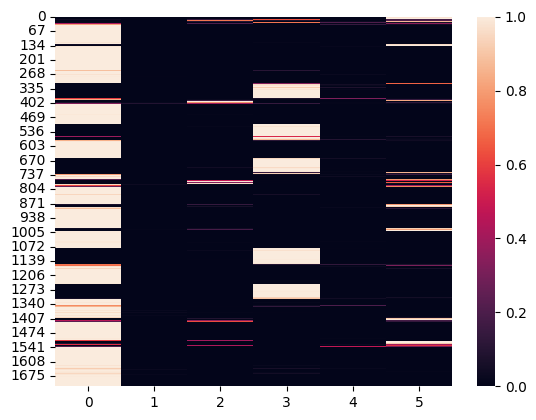

In [16]:
import seaborn as sns
sns.heatmap(preds[0])

***K MEANS CLUSTERING***

In [18]:
# Assuming your dataset is called 'data' and has a shape of (1200, 1723, 6)
n_samples, n_frames, n_features = preds.shape
data_2d = preds.reshape(n_samples * n_frames, n_features)


In [19]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(data_2d)
kmeans.fit(data_2d)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=6, random_state=0)

In [22]:
cluster_assignments = kmeans.labels_


In [26]:
cluster_assignments.shape, 1200*1723

((2067600,), 2067600)

(2067600, 6)

In [35]:
torch.argmax(torch.reshape(torch.tensor(B), (B.shape[0]*B.shape[1], B.shape[2]) ), dim = -1)

tensor([1, 1, 1,  ..., 5, 5, 5])

In [37]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(  torch.argmax(torch.reshape(torch.tensor(B), (B.shape[0]*B.shape[1], B.shape[2]) ), dim = -1) , cluster_assignments)
nmi = normalized_mutual_info_score(torch.argmax(torch.reshape(torch.tensor(B), (B.shape[0]*B.shape[1], B.shape[2]) ), dim = -1), cluster_assignments)

print(f'Adjusted Rand Index: {ari}')
print(f'Normalized Mutual Information: {nmi}')


Adjusted Rand Index: 0.5830187378635663
Normalized Mutual Information: 0.36111625206722764


K means clustering gave horrible results as our assumption that each unknown stroke will map to a different vector in an n-dimensional space, it turns out to be valid only for models which are very well trained and have seen loads and loads of training data. I want to pass in other courses too.

***GAUSSIAN MEAN MIXTURE***

In [42]:
import numpy as np
from sklearn.mixture import GaussianMixture


In [43]:
n_samples, n_frames, n_features = preds.shape
data_2d = preds.reshape(n_samples * n_frames, n_features)
n_components = 6
gmm = GaussianMixture(n_components=n_components, random_state=0)
gmm.fit(data_2d)
cluster_assignments = gmm.predict(data_2d)


In [44]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(torch.argmax(torch.reshape(torch.tensor(B), (B.shape[0]*B.shape[1], B.shape[2]) ), dim = -1), cluster_assignments)
nmi = normalized_mutual_info_score(torch.argmax(torch.reshape(torch.tensor(B), (B.shape[0]*B.shape[1], B.shape[2]) ), dim = -1), cluster_assignments)

print(f'Adjusted Rand Index: {ari}')
print(f'Normalized Mutual Information: {nmi}')


Adjusted Rand Index: 0.44139056585934144
Normalized Mutual Information: 0.3070233023573093


GMM gave even worse results. FML!

In [45]:
means = gmm.means_
covariances = gmm.covariances_


In [46]:
means, covariances

(array([[5.37572029e-03, 1.08265206e-04, 4.32633710e-01, 1.50868836e-02,
         1.87955742e-02, 5.27999847e-01],
        [9.99640202e-01, 8.83625807e-05, 1.61412931e-05, 8.07379128e-05,
         8.68201190e-05, 8.77491088e-05],
        [7.53848883e-05, 8.97925027e-05, 2.17636533e-04, 9.99125695e-01,
         3.36410219e-04, 1.55085129e-04],
        [4.21271113e-01, 8.08609626e-05, 9.26873198e-04, 7.54643558e-04,
         1.92978247e-03, 5.75036729e-01],
        [1.90193957e-01, 9.71844424e-03, 7.20142817e-02, 2.74282094e-01,
         3.06016479e-01, 1.47774743e-01],
        [5.49262201e-01, 1.13614708e-01, 3.49994346e-04, 3.19675794e-01,
         1.65497676e-02, 5.47537971e-04]]),
 array([[[ 1.68173848e-04,  5.19472087e-07, -5.20027943e-04,
           8.16557825e-06,  2.46976795e-05,  3.19471362e-04],
         [ 5.19472087e-07,  1.24584340e-06,  1.30865913e-05,
           2.90600545e-07,  3.21334954e-07, -1.44638423e-05],
         [-5.20027943e-04,  1.30865913e-05,  1.68578165e-01,
 

***Prototypical neural network***